# N-ACT Tutorial: Using N-ACT's Interpretability for Annotating SCP 1361

In this notebook, we will go over how to load a pre-trained NACT model and how to generate a list of attentive genes for querying and annotating cell types.

In [1]:
try:
    from nbproject import header
    header(filepath="/home/aheydari/NACT_Project/NACT_Evaluation/"
           "AttentionAnalysis/"
           "NACT_tutorial_braod_celltype_annotation_SCP1361.ipynb")

except ModuleNotFoundError:
    print("Please install nbproject (pip install nbproject) to see header"
         "dependencies.")

ℹ️ Assuming editor is Jupyter Lab.


id,2tOrFqO6sriR
version,0
time_init,2023-01-25 19:59
time_run,2023-01-25 21:50
pypackage,nact==0.1.0 nbproject==0.8.1 numpy==1.23.5 pandas==1.5.2 scanpy==1.7.0 torch==1.13.1


In [2]:
import nact
from nact.utilities import *
from nact import scanpy_to_dataloader
from nact import AttentionQuery
import numpy as np
import os
import pandas as pd
import scanpy as sc
import torch

In [3]:
print(f"NACT Version: {nact.__version__}")
print(f"Scanpy Version: {sc.__version__}")

NACT Version: 0.1.0
Scanpy Version: 1.7.0


In [4]:
%load_ext autoreload
%autoreload 2

## Setting Up Result Folder and Data Paths

In [5]:
abs_path = "/home/aheydari/"
local_path = "data/NACT_Data/Supervised Benchmarking/"

In [6]:
# label for the dataset folder we want to make
dataset_name = "SCP1361"
# directory for specific dataset
dataset_dir = f"./{dataset_name}" 
# subdir where we store cluster attention and attention means
results = f"./{dataset_name}/results" 
# subdir where we store cluster enrichment plots
plots = f"./{dataset_dir}/plots" 

In [7]:
# dataset dir
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print(f"Directory {dataset_name} created for saving dataset results")
    
else:
    print("Directory already exists!")


# results dir to store attention values
if not os.path.exists(results):
    os.makedirs(results)
    print(f"Sub-directory {dataset_name} created for storing attention")
    
else:
    print("Directory already exists!")

# dataset subdir enrichment plots
if not os.path.exists(plots):
    os.makedirs(plots)
    print(f"Directory created for saving {dataset_name} Attention"
          "enrichment plots")
    
else:
    print("Directory already exists!")

Directory SCP1361 created for saving dataset results
Sub-directory SCP1361 created for storing attention
Directory created for saving SCP1361 Attentionenrichment plots


## Load in pre-trained NACT model

Since our implementation is in pytorch, we can use the `load` funtion that pytorch provides. Our model is stored as a dict, with `epoch` corresponding to the current epoch, and `Saved_Model` corresponding to the model.

## Load in the data that we want

For example, here we will load in cluster 1 

In [8]:
path_to_data = (f"{abs_path}{local_path}{dataset_name}"
                "_qc_hvg_anno_5k_raw_train_split.h5ad")

In [9]:
train_data_loader, test_data_loader = scanpy_to_dataloader(path_to_data,
                                                test_no_valid = True, 
                                                verbose = False, 
                                                raw_x = True)

==> Reading in Scanpy/Seurat AnnData
    -> Trying adata.raw.X instead of adata.X!
    -> Splitting Train and Validation Data
==> Using cluster info for generating train and validation labels
==> Checking if we have sparse matrix into dense


In [10]:
model_dict = torch.load(f"{abs_path}data/NACT_Trained_Models/"
                              "NACT_Jan2023Benchmarks/NACT-Pojections+Attention"
                              f"-{dataset_name}-1Heads-Bestmodel_Best.pth",
                              map_location=torch.device('cpu'))

trained_nact_model = model_dict["Saved_Model"]
trained_nact_model.eval()

NACTProjectionAttention(
  (masking_layer): Identity()
  (attention_module): Linear(in_features=5000, out_features=5000, bias=True)
  (projection_block1): Projection(
    (projection): Linear(in_features=5000, out_features=5000, bias=True)
    (output_dropout): Dropout(p=0.0, inplace=False)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (projection_block2): Projection(
    (projection): Linear(in_features=5000, out_features=5000, bias=True)
    (output_dropout): Dropout(p=0.0, inplace=False)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (pwff): PointWiseFeedForward(
    (first_layer): Sequential(
      (0): Linear(in_features=5000, out_features=128, bias=True)
      (1): ReLU()
    )
    (second_layer): Linear(in_features=128, out_features=5000, bias=True)
    (normalization): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (task_module): Sequential(
    (0): Linear(in_features=5000, out_features=10, bi

In [11]:
if torch.cuda.is_available():
        device = "cuda";
        print('==> Using GPU (CUDA)')
        
elif(torch.backends.mps.is_available()):
    device = torch.device("mps");
    print('==> Using M1 GPUs')

else:
    device = "cpu"
    print('==> Using CPU')
    print('    -> Warning: Using CPUs will yield to slower training time than GPUs')
    
trained_nact_model.device = device

==> Using GPU (CUDA)


### Checking the Accuracy of the Model on Data for Validation

In [12]:
_, _ , _ , _ ,  _ = evaluate_classifier(test_data_loader, 
                    trained_nact_model, 
                    classification_report=True,
                    device=trained_nact_model.device)

==> Evaluating on Validation Set:
    -> Accuracy of classifier network on validation set:95.7083 %
    -> Non-Weighted F1 Score on validation set: 0.9563
    -> Weighted F1 Score on validation set: 0.9572
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       617
         1.0       1.00      0.98      0.99       269
         2.0       0.90      0.94      0.92       196
         3.0       0.99      0.98      0.98       163
         4.0       0.95      0.95      0.95      1432
         5.0       0.98      0.96      0.97       543
         6.0       0.87      0.90      0.89       500
         7.0       1.00      0.96      0.98        57
         8.0       0.93      0.90      0.91       143
         9.0       0.98      0.99      0.98       880

    accuracy                           0.96      4800
   macro avg       0.96      0.95      0.96      4800
weighted avg       0.96      0.96      0.96      4800



Get the actual population names for comparison

In [13]:
adata = sc.read(path_to_data)
celltypes = adata.obs['celltypes'].cat.categories.tolist()
cluster_list = [f'Cluster_{i}' for i in range(len(celltypes))]
celltype_dict = {cluster_list[i]: celltypes[i] for i in range(len(celltypes))}

In [14]:
celltype_dict

{'Cluster_0': 'B cell',
 'Cluster_1': 'T cell',
 'Cluster_2': 'dendritic cell',
 'Cluster_3': 'endothelial cell',
 'Cluster_4': 'fibroblast',
 'Cluster_5': 'macrophage',
 'Cluster_6': 'mesothelial cell',
 'Cluster_7': 'neural cell',
 'Cluster_8': 'pericyte cell',
 'Cluster_9': 'smooth muscle cell'}

## Attentive Genes and Querying for Annotation

In [15]:
query_object = AttentionQuery(adata, split_test=True, model=trained_nact_model)
tf_idf_df, _, _ = query_object.get_gene_query(use_raw_x=True, 
                                              verbose=False, 
                                              correct_predictions_only=False, 
                                              mode="tfidf")

==> Splitting the data to 'test' only:
==> Top 100 genes will be selected in tfidf mode
==> Getting Top 100 genes for each cluster in the data
>-< Done with all clusters


==> Performing enrichment test on top 50 genes.
    -> Results per gene set:
    -> Results for combine score:


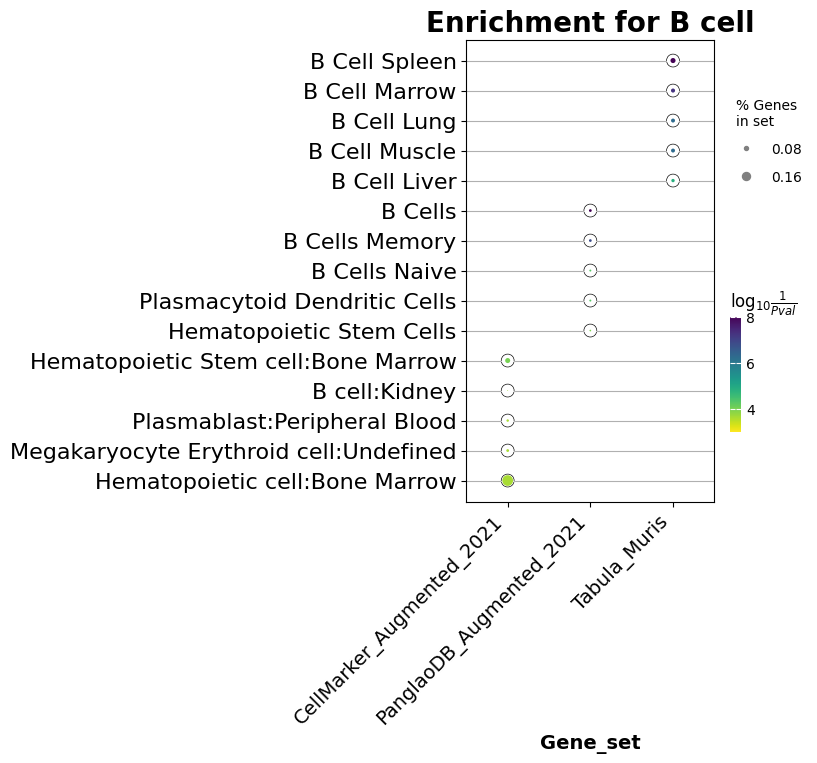

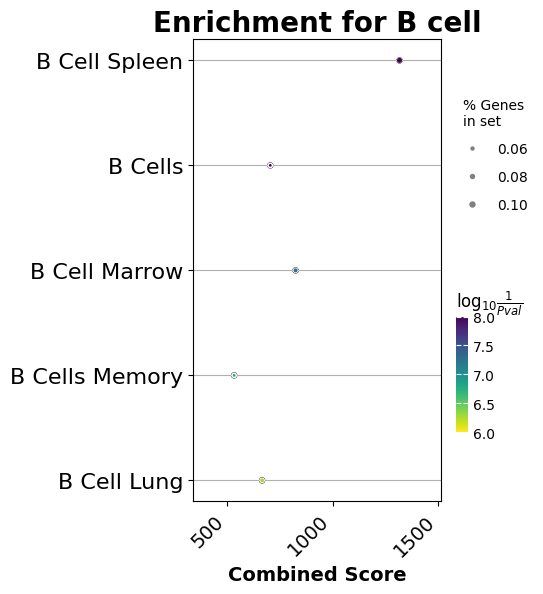

In [16]:
query_object.make_enrichment_plots(
                              number_of_genes_to_query= 50,
                              which_cluster= 0,
                              return_results = False,
                              species="mouse",
                              clusters_to_names_dict= celltype_dict,
                              save=False,
                              verbose=True)

==> Performing enrichment test on top 50 genes.
    -> Results per gene set:
    -> Results for combine score:


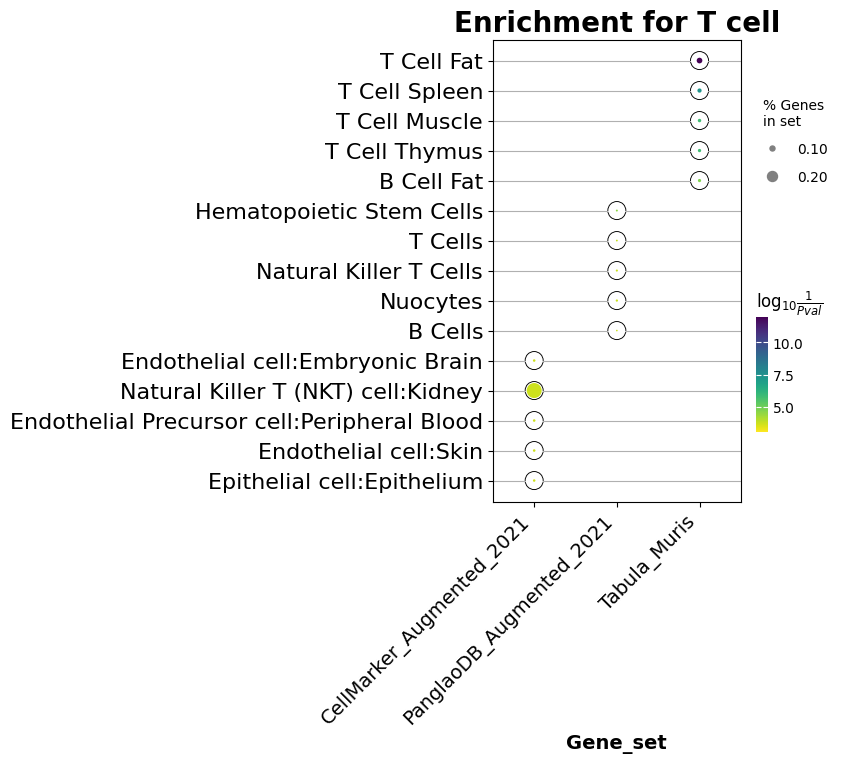

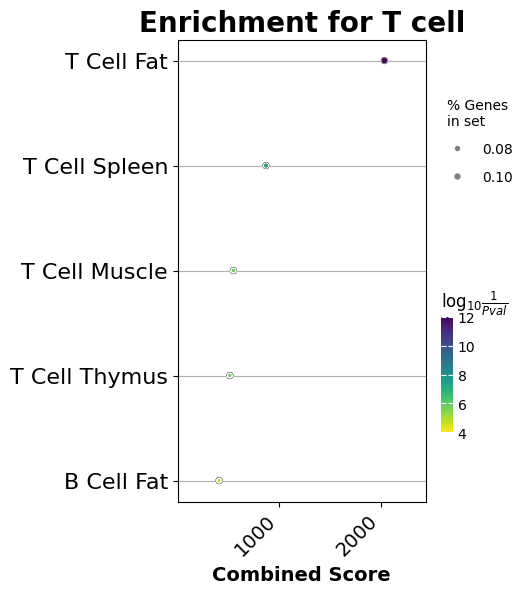

In [17]:
query_object.make_enrichment_plots(
                              number_of_genes_to_query= 50,
                              which_cluster= 1,
                              return_results = False,
                              species="mouse",
                              clusters_to_names_dict= celltype_dict,
                              save=False,
                              verbose=True)

==> Performing enrichment test on top 50 genes.
    -> Results per gene set:
    -> Results for combine score:


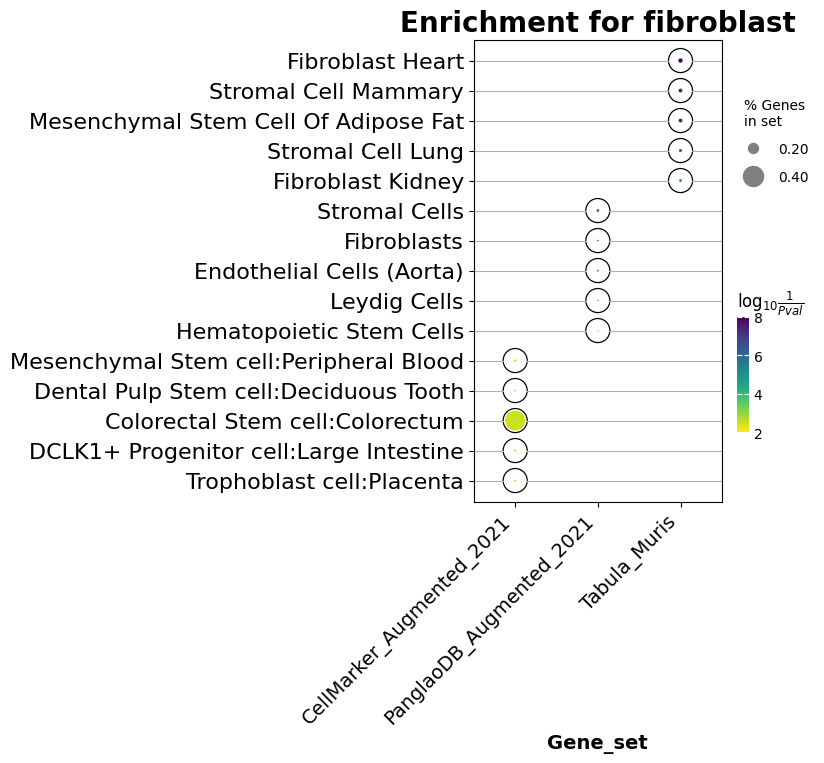

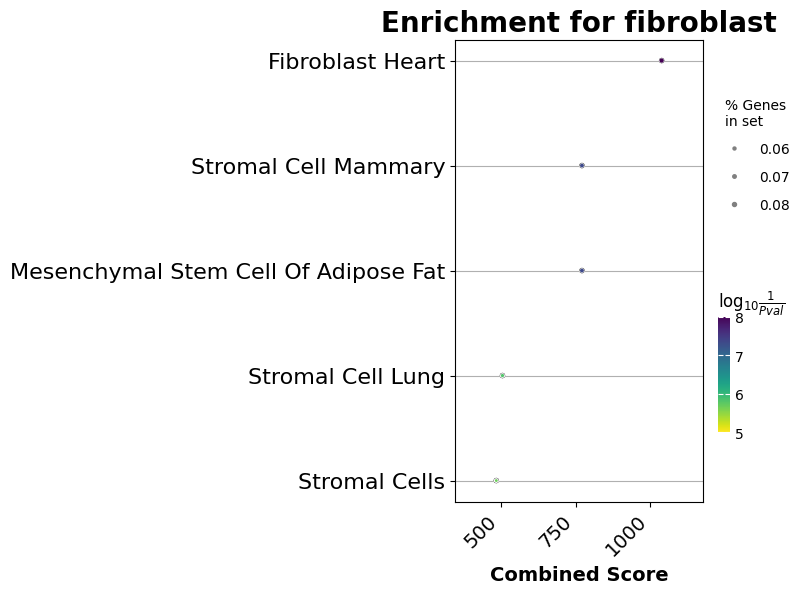

In [18]:
query_object.make_enrichment_plots(
                              number_of_genes_to_query= 50,
                              which_cluster= 4,
                              return_results = False,
                              species="mouse",
                              clusters_to_names_dict= celltype_dict,
                              save=False,
                              verbose=True)

# Not Normalizing By TFIDF

In [19]:
query_object = AttentionQuery(adata, split_test=True, model=trained_nact_model)
mean_based_list_df, _, _ = query_object.get_gene_query(
                                                use_raw_x=True, 
                                                verbose=False, 
                                                correct_predictions_only=True,
                                                mode="mean")

==> Splitting the data to 'test' only:
    -> **Returning only the correct predictions**
==> Top 100 genes will be selected in mean mode
==> Getting Top 100 genes for each cluster in the data
>-< Done with all clusters


==> Performing enrichment test on top 50 genes.
    -> Results per gene set:
    -> Results for combine score:


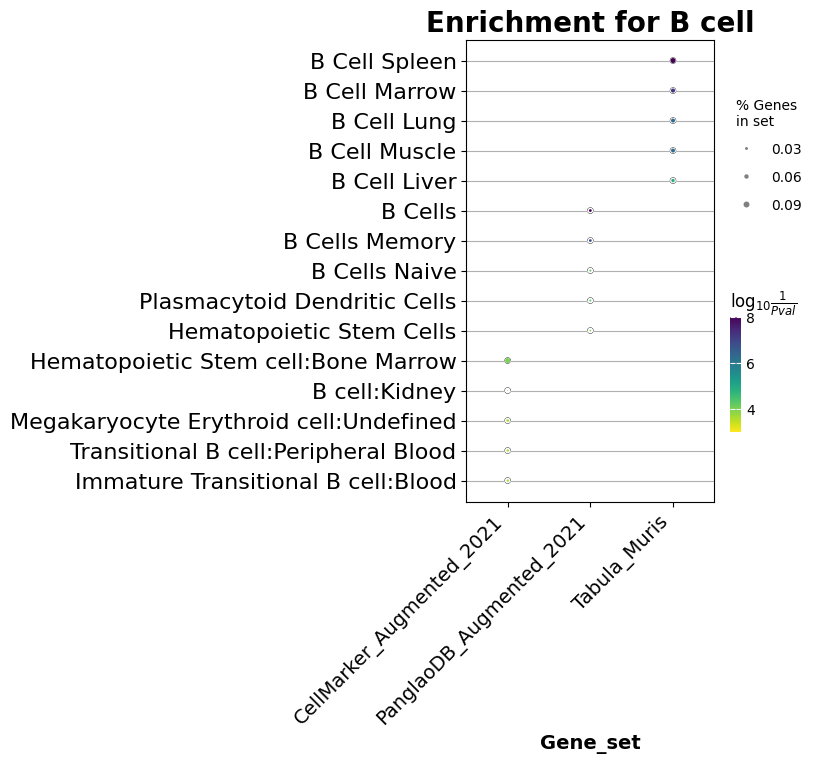

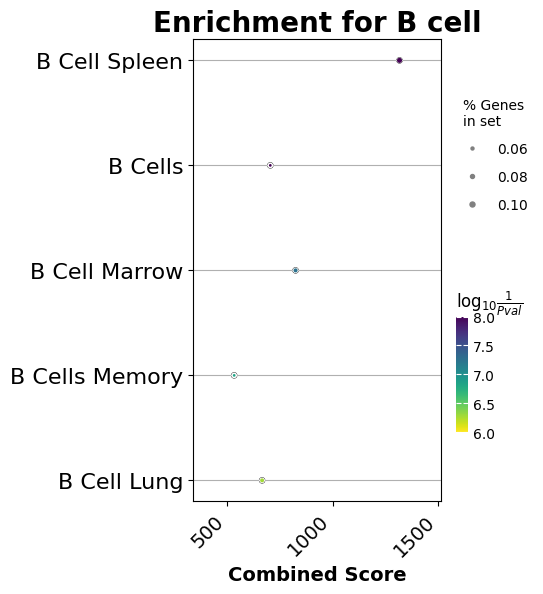

In [20]:
query_object.make_enrichment_plots(
                              number_of_genes_to_query= 50,
                              which_cluster= 0,
                              return_results = False,
                              species="mouse",
                              clusters_to_names_dict= celltype_dict,
                              save=False,
                              verbose=True)

==> Performing enrichment test on top 50 genes.
    -> Results per gene set:
    -> Results for combine score:


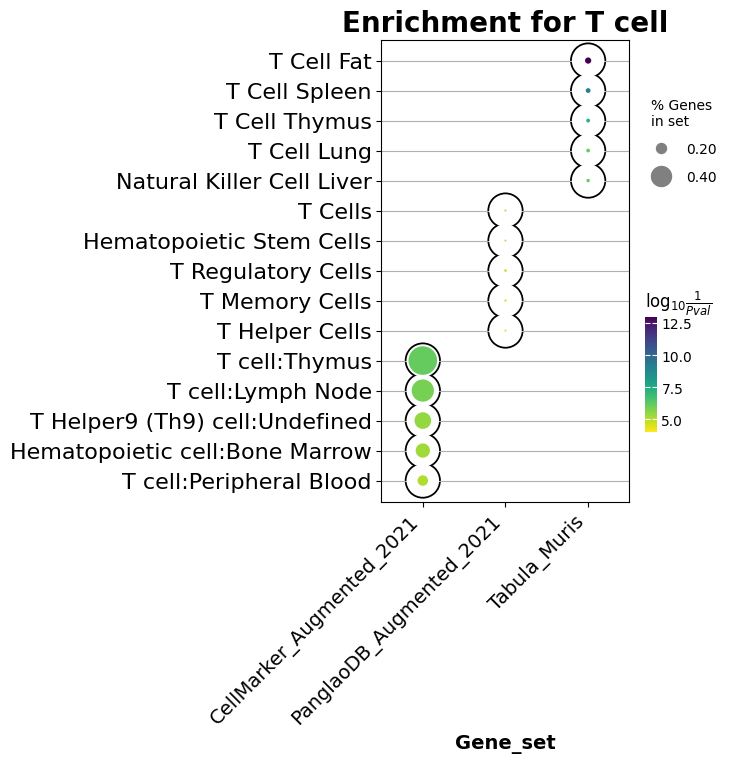

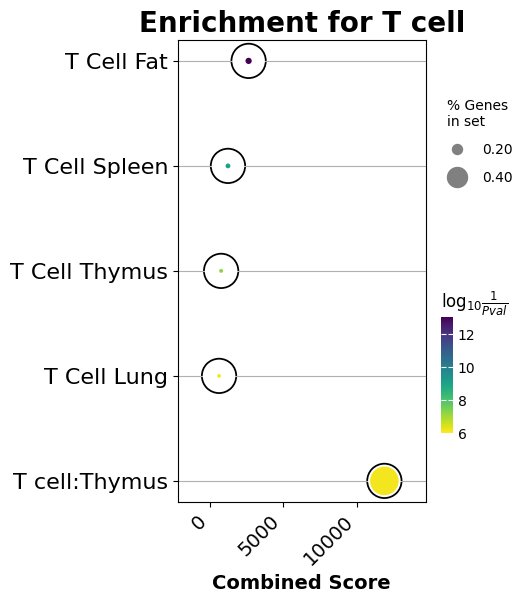

In [22]:
query_object.make_enrichment_plots(
                              number_of_genes_to_query= 50,
                              which_cluster= 1,
                              return_results = False,
                              species="mouse",
                              clusters_to_names_dict= celltype_dict,
                              save=False,
                              verbose=True)